# Seq2seq Chat-bot

In [1]:
# Read training data
'''
questions = []
answers = []
is_q = True
counter = 0
with open("clr_conversation.txt", mode="r") as f:
    for line in f:
        if is_q:
            questions.extend(line.strip().split())
            is_q = False
        else:
            answers.extend(line.strip().split())
            is_q = True
'''

'\nquestions = []\nanswers = []\nis_q = True\ncounter = 0\nwith open("clr_conversation.txt", mode="r") as f:\n    for line in f:\n        if is_q:\n            questions.extend(line.strip().split())\n            is_q = False\n        else:\n            answers.extend(line.strip().split())\n            is_q = True\n'

# Seq2seq Transaltion

ref
- [keras blog](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)
    - [github](https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py)

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from keras.models import Model
from keras.layers import *

/home/sitibanc/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Parameters

In [3]:
batch_size = 256  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = "fra.txt"

## Data Preprocessing

In [4]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n") # txt format: ENG\tFR\n
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split("\t")    # Split x/y
    # We use "\t" as "BOS" token
    # for the targets, and "\n" as "EOS" token
    target_text = "\t" + target_text + "\n"    # Add tokens
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [5]:
# set to list and sort
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
# count input and target languages tokens (may be different)
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
# count max sequence length of input and target language data respectively (may be different)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [6]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 94
Max sequence length for inputs: 16
Max sequence length for outputs: 59


In [7]:
# Build (char2index) dictionary
input_char2index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_char2index = dict(
[(char, i) for i, char in enumerate(target_characters)])

In [8]:
# One-hot Encoding
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):    # zip to create (input, target) tuples
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_char2index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_char2index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_char2index[char]] = 1.

## Build Model

In [9]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens), name="encoder_input")    # 16*71
encoder_outputs, state_h, state_c = LSTM(latent_dim, return_state=True, name="encoder_lstm")(encoder_inputs)    # 16*256, 16*256, 16*256
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens), name="decoder_input")    # 59*94
decoder_outputs, _, _ = LSTM(latent_dim, return_sequences=True, return_state=True, name="decoder_lstm")(decoder_inputs, initial_state=encoder_states)    # 59*256
decoder_outputs = Dense(num_decoder_tokens, activation="softmax", name="decoder_output")(decoder_outputs)    # 59*94

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name="seq2seq")

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, None, 71)     0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      (None, None, 94)     0                                            
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, 256), (None, 335872      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(None, None, 256),  359424      decoder_input[0][0]              
                                                                 encoder_lstm[0][1]               
          

## Train Model

In [10]:
model.compile(optimizer="adam", loss="categorical_crossentropy")
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 24s 3ms/step - loss: 1.1334 - val_loss: 1.1457
Epoch 2/100
9000/9000 [==============================] - 22s 2ms/step - loss: 0.9364 - val_loss: 1.1066
Epoch 3/100
9000/9000 [==============================] - 23s 3ms/step - loss: 0.8983 - val_loss: 1.0524
Epoch 4/100
9000/9000 [==============================] - 23s 3ms/step - loss: 0.8459 - val_loss: 0.9794
Epoch 5/100
9000/9000 [==============================] - 23s 3ms/step - loss: 0.7816 - val_loss: 0.9065
Epoch 6/100
9000/9000 [==============================] - 23s 3ms/step - loss: 0.7281 - val_loss: 0.8665
Epoch 7/100
9000/9000 [==============================] - 23s 3ms/step - loss: 0.6864 - val_loss: 0.8258
Epoch 8/100
9000/9000 [==============================] - 23s 3ms/step - loss: 0.6523 - val_loss: 0.7917
Epoch 9/100
9000/9000 [==============================] - 23s 3ms/step - loss: 0.6261 - val_loss: 0.7663
Epoch 10/100
900

9000/9000 [==============================] - 23s 3ms/step - loss: 0.2692 - val_loss: 0.5051
Epoch 79/100
9000/9000 [==============================] - 23s 3ms/step - loss: 0.2668 - val_loss: 0.5052
Epoch 80/100
9000/9000 [==============================] - 23s 3ms/step - loss: 0.2648 - val_loss: 0.5020
Epoch 81/100
9000/9000 [==============================] - 23s 3ms/step - loss: 0.2608 - val_loss: 0.5059
Epoch 82/100
9000/9000 [==============================] - 23s 3ms/step - loss: 0.2591 - val_loss: 0.5034
Epoch 83/100
9000/9000 [==============================] - 23s 3ms/step - loss: 0.2565 - val_loss: 0.5094
Epoch 84/100
9000/9000 [==============================] - 23s 3ms/step - loss: 0.2552 - val_loss: 0.5052
Epoch 85/100
9000/9000 [==============================] - 23s 3ms/step - loss: 0.2520 - val_loss: 0.5087
Epoch 86/100
9000/9000 [==============================] - 23s 3ms/step - loss: 0.2489 - val_loss: 0.5077
Epoch 87/100
9000/9000 [==============================] - 23s 3ms/st

In [11]:
# Save model
model.save("seq2seq-translate.h5")

/home/sitibanc/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py:2368: UserWarning: Layer decoder_lstm was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_lstm/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'encoder_lstm/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


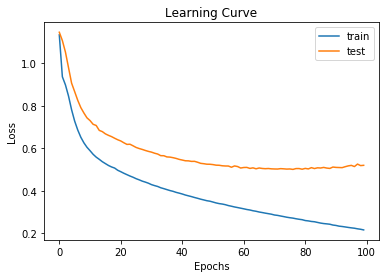

In [12]:
# Plot learning curve
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.show()

## Inference

In [13]:
# Define Encoder & Decoder Model
encoder_model = Model(encoder_inputs, encoder_states, name="Encoder")

decoder_state_input_h = Input(shape=(latent_dim,), name="hidden_state_input")
decoder_state_input_c = Input(shape=(latent_dim,), name="memory_cell_input")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]    # decoder initial states
decoder_outputs, state_h, state_c = model.get_layer("decoder_lstm")(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = model.get_layer("decoder_output")(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states, name="Decoder")

In [14]:
# Build (index2char) dictionary for reverse lookup
input_index2char = dict(
    (i, char) for char, i in input_char2index.items())
target_index2char = dict(
    (i, char) for char, i in target_char2index.items())

In [15]:
def decode_sequence(input_seq):
    '''
    Args:
        input_seq: ndarray, encoder input
    '''
    # Encode the input as state vectors.
    # Get (initial) state value from encoder give input_seq
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1. (1 sentence, 1 char which is a num_decoder_tokens vector)
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character (<BOS> token).
    target_seq[0, 0, target_char2index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        # Get prediction(along with hidden state h, and memory cell c) from decoder (character-wise)
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = target_index2char[sampled_token_index]    # lookup from index2char dict
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.
        #target_seq = output_tokens

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [16]:
for seq_index in range(50):
    # Take one sequence (from training data)
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Allez-vous !

-
Input sentence: Run!
Decoded sentence: Ariliez !

-
Input sentence: Run!
Decoded sentence: Ariliez !

-
Input sentence: Fire!
Decoded sentence: Au feu !

-
Input sentence: Help!
Decoded sentence: Aide-moi !

-
Input sentence: Jump.
Decoded sentence: Saute.

-
Input sentence: Stop!
Decoded sentence: Arrêtez-vous !

-
Input sentence: Stop!
Decoded sentence: Arrêtez-vous !

-
Input sentence: Stop!
Decoded sentence: Arrêtez-vous !

-
Input sentence: Wait!
Decoded sentence: Attendez !

-
Input sentence: Wait!
Decoded sentence: Attendez !

-
Input sentence: Go on.
Decoded sentence: Allez !

-
Input sentence: Go on.
Decoded sentence: Allez !

-
Input sentence: Go on.
Decoded sentence: Allez !

-
Input sentence: I see.
Decoded sentence: Je l'ai ressé.

-
Input sentence: I try.
Decoded sentence: Je plaise.

-
Input sentence: I won!
Decoded sentence: Je vous ai !

-
Input sentence: I won!
Decoded sentence: Je vous ai !

-
Input sentence: Oh

## Test (Single word)

In [17]:
test_seq = "Hi"
# One-hot Encoding
onehot_test_seq = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
for t, char in enumerate(test_seq):
    onehot_test_seq[0, t, input_char2index[char]] = 1.

decoded_sentence = decode_sequence(onehot_test_seq)
print('Input sentence:', test_seq)
print('Decoded sentence:', decoded_sentence)

Input sentence: Hi
Decoded sentence: Ent-el !

